In [ ]:
import os
import pysam
import subprocess
import pandas as pd
from tqdm import tqdm
import shutil
import glob
from scipy.stats import wasserstein_distance

WORK_DIR = "/mnt/qmtang/EvoFill/data/251020_ver01_chr22/"
TARGET_VCF = "/home/qmtang/GitHub/STICI-HPC/data/training_sets/ALL.chr22.training.samples.100k.any.type.0.01.maf.variants.vcf.gz"

KGP_VCF_TMPL = "/mnt/NAS/Omics/DNA/1kGP/vcf/ALL.chr{chr}.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz"
KGP_PED = "/mnt/NAS/Omics/DNA/1kGP/meta/20130606_g1k.ped"
VCF2DIS = "/home/qmtang/GitHub/VCF2Dis/bin/VCF2Dis"

os.makedirs(WORK_DIR, exist_ok=True)
def run(cmd):
    """Run shell cmd; suppress stdout/stderr unless error."""
    p = subprocess.run(cmd, shell=True,
                       stdout=subprocess.DEVNULL,
                       stderr=subprocess.PIPE,
                       encoding="utf-8")
    if p.returncode:
        raise subprocess.CalledProcessError(p.returncode, cmd, output=p.stderr)

In [36]:
def step1_target_roi_and_rename(vcf, outdir):
    print("【1】提取目标位点 + 样本加前缀 T-")
    # 1.1 位点 bed
    bed_path = os.path.join(outdir, "target_sites.bed")
    with pysam.VariantFile(vcf) as invcf, open(bed_path, "w") as f:
        for rec in invcf:
            f.write(f"{rec.chrom}\t{rec.pos-1}\t{rec.pos}\n")
    run(f"sort -k1,1 -k2,2n {bed_path} | bgzip -c > {bed_path}.gz")
    run(f"tabix -pbed {bed_path}.gz")

    # 1.2 重命名样本
    renamed_vcf = os.path.join(outdir, "target_rename.vcf.gz")
    sample_map = os.path.join(outdir, "rename_map.txt")
    with pysam.VariantFile(vcf) as invcf:
        with open(sample_map, "w") as fm:
            for s in invcf.header.samples:
                fm.write(f"{s}\tT-{s}\n")
    run(f"bcftools reheader -s {sample_map} -o {renamed_vcf} {vcf}")
    run(f"tabix -p vcf {renamed_vcf}")
    return f"{bed_path}.gz", renamed_vcf

bed_roi, target_renamed = step1_target_roi_and_rename(TARGET_VCF, WORK_DIR)
print("bed_roi =", bed_roi)
print("target_renamed =", target_renamed)

【1】提取目标位点 + 样本加前缀 T-
bed_roi = /mnt/qmtang/EvoFill/data/251020_ver01_chr22/target_sites.bed.gz
target_renamed = /mnt/qmtang/EvoFill/data/251020_ver01_chr22/target_rename.vcf.gz


In [37]:
def step2_extract_1kgp(roi_bed, outdir):
    print("【2】提取 1kGP 对应位点 & 保留 ped 存在样本")
    # 2.1 染色体列表
    with pysam.TabixFile(roi_bed) as t:
        chrs = list(t.contigs)
    extracted = []
    for ch in tqdm(chrs, desc="chr"):
        kgp_vcf = KGP_VCF_TMPL.format(chr=ch)
        out = os.path.join(outdir, f"kgp_{ch}.vcf.gz")
        run(f"bcftools view -R {roi_bed} -Oz -o {out} {kgp_vcf} --threads 8")
        run(f"tabix -p vcf {out}")
        extracted.append(out)
    merged = os.path.join(outdir, "kgp_targetSites.vcf.gz")
    run(f"bcftools concat -Oz -o {merged} {' '.join(extracted)} --threads 8")
    run(f"tabix -p vcf {merged}")

    # 2.2 与 ped 取交集
    ped_df = pd.read_csv(KGP_PED, sep="\t", usecols=["Individual ID", "Population"])
    ped_df.columns = ["sample", "pop"]
    real_samples = set(pysam.VariantFile(merged).header.samples)
    ped_df = ped_df[ped_df["sample"].isin(real_samples)]
    ped_df.to_csv(os.path.join(outdir, "kgp_meta_clean.tsv"), sep="\t", index=False)
    return merged, ped_df

kgp_vcf, kgp_meta = step2_extract_1kgp(bed_roi, WORK_DIR)
print("kgp_vcf =", kgp_vcf)
print("kgp_meta head:\n", kgp_meta.head())

【2】提取 1kGP 对应位点 & 保留 ped 存在样本


chr: 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]

kgp_vcf = /mnt/qmtang/EvoFill/data/251020_ver01_chr22/kgp_targetSites.vcf.gz
kgp_meta head:
     sample  pop
0  HG01879  ACB
1  HG01880  ACB
3  HG01882  ACB
4  HG01883  ACB
7  HG01885  ACB


In [38]:
def step3_split_pop_and_merge(kgp_vcf, kgp_meta, target_vcf, outdir):
    print("【3】按种群分割 1kGP 并与目标 merge")
    pops = sorted(kgp_meta["pop"].unique())
    merge_vcfs = {}
    for pop in pops:
        pop_samples = kgp_meta[kgp_meta["pop"] == pop]["sample"].tolist()
        list_file = os.path.join(outdir, f"{pop}.list")
        with open(list_file, "w") as f:
            for s in pop_samples:
                f.write(s + "\n")
        pop_vcf = os.path.join(outdir, f"kgp_{pop}.vcf.gz")
        run(f"bcftools view -S {list_file} -Oz -o {pop_vcf} {kgp_vcf} --threads 8")
        run(f"tabix -p vcf {pop_vcf}")

        merge_vcf = os.path.join(outdir, f"merge_{pop}.vcf.gz")
        run(f"bcftools merge -Oz -o {merge_vcf} {target_vcf} {pop_vcf} --threads 8")
        run(f"tabix -p vcf {merge_vcf}")
        merge_vcfs[pop] = merge_vcf
    return merge_vcfs

pop_merge_vcfs = step3_split_pop_and_merge(kgp_vcf, kgp_meta, target_renamed, WORK_DIR)
print("generated merge vcfs:", list(pop_merge_vcfs.keys()))

【3】按种群分割 1kGP 并与目标 merge
generated merge vcfs: ['ACB', 'ASW', 'BEB', 'CDX', 'CEU', 'CHB', 'CHS', 'CLM', 'ESN', 'FIN', 'GBR', 'GIH', 'GWD', 'IBS', 'ITU', 'JPT', 'KHV', 'LWK', 'MSL', 'MXL', 'PEL', 'PJL', 'PUR', 'STU', 'TSI', 'YRI']


In [ ]:
def read_dist_mat(path):
    """VCF2Dis 特殊格式：跳过第 1 行，第 1 列 = 行名 = 列名"""
    with open(path) as f:
        next(f)                      # 跳过首行
        tokens = [l.strip().split() for l in f]
    idx = [t[0] for t in tokens]     # 第一列 = 样本名
    data = [list(map(float, t[1:])) for t in tokens]
    return pd.DataFrame(data, index=idx, columns=idx)

def step4_wasserstein(pop_vcfs, outdir):
    print("【4】计算 T- 样本 → 1kGP 内部分布的 Wasserstein 距离")
    dist_csv = os.path.join(outdir, "pop_wasserstein.tsv")
    records = pd.DataFrame()

    for pop, vcf in tqdm(pop_vcfs.items(), desc="pop"):
        mat = os.path.join(outdir, f"dist_{pop}.mat")
        run(f"{VCF2DIS} -InPut {vcf} -OutPut {mat}")
        df_dist = read_dist_mat(mat)

        # 行列名称统一
        df_dist.index = df_dist.index.astype(str)
        df_dist.columns = df_dist.columns.astype(str)

        # 区分 T- 与 1kGP
        test_mask  = df_dist.index.str.startswith("T-")
        kgp_mask   = ~test_mask
        test_samps = df_dist.index[test_mask]
        kgp_samps  = df_dist.index[kgp_mask]

        # 1kGP 内部参考分布：上三角距离，避免重复
        kgp_distances = []
        kgp_sub = df_dist.loc[kgp_samps, kgp_samps]
        for i in range(len(kgp_sub)):
            for j in range(i+1, len(kgp_sub)):
                kgp_distances.append(kgp_sub.iloc[i, j])

        # 对每个 T- 样本计算到 1kGP 所有样本的距离分布
        for t_s in test_samps:
            t_distances = df_dist.loc[t_s, kgp_samps].values
            wass = wasserstein_distance(t_distances, kgp_distances)
            records.loc[t_s, pop]= 1000*wass
    records.to_csv(dist_csv, sep="\t")
    return dist_csv

final_table = step4_wasserstein(pop_merge_vcfs, WORK_DIR)
print("Wasserstein 距离表格 →", final_table)

【4】计算 T- 样本 → 1kGP 内部分布的 Wasserstein 距离


pop: 100%|██████████| 26/26 [04:11<00:00,  9.66s/it]

Wasserstein 距离表格 → /mnt/qmtang/EvoFill/data/251020_ver01_chr22/pop_wasserstein.tsv


In [40]:
df = pd.read_csv(final_table, sep="\t", index_col=0)
df.index = df.index.str.removeprefix("T-")   # Python≥3.9
df.to_csv(final_table, sep="\t")
print("已去前缀 →", final_table)
df.head()

已去前缀 → /mnt/qmtang/EvoFill/data/251020_ver01_chr22/pop_wasserstein.tsv


,ACB,ASW,BEB,CDX,CEU,CHB,CHS,CLM,ESN,FIN,...,KHV,LWK,MSL,MXL,PEL,PJL,PUR,STU,TSI,YRI
HG00096,1.381926,0.673327,2.548350,3.435138,1.488611,4.067052,3.956237,2.178311,3.759898,2.123391,...,3.497290,2.262606,3.122087,3.918074,7.358262,2.738216,1.297281,1.898430,1.971786,3.255225
HG00097,0.634437,0.682151,1.220621,3.755562,0.936871,3.598779,3.914964,0.911656,1.865911,0.943885,...,2.883506,1.517745,2.296903,2.448236,5.268989,1.076637,0.969970,1.954439,0.538231,2.125300
HG00099,0.793394,0.640887,1.196147,3.163067,2.539672,4.033493,3.986936,2.684057,2.659731,2.836891,...,3.425178,1.490817,2.058319,4.221021,6.341458,1.944859,1.665358,1.489904,2.388548,2.722670
HG00100,1.101444,2.340331,1.537079,0.840857,1.790982,0.704396,0.810411,2.238819,1.275659,0.924337,...,0.854737,0.702606,1.613256,0.875804,1.448399,1.801112,2.434940,2.296145,2.287260,1.303244
HG00101,4.976523,5.510174,3.241991,2.819951,2.550897,1.222691,1.047477,3.514227,3.541039,2.159877,...,2.485927,3.463921,3.237721,2.320343,0.974564,2.738490,3.730142,3.941183,2.610188,3.481959


In [41]:
keep = {final_table}   # 保留列表
for f in glob.glob(WORK_DIR+"*"):
    if f not in keep:
        if os.path.isdir(f):
            shutil.rmtree(f)
        else:
            os.remove(f)
print("中间文件已清理，仅保留：", *glob.glob(WORK_DIR+"*"))

中间文件已清理，仅保留： /mnt/qmtang/EvoFill/data/251020_ver01_chr22/pop_wasserstein.tsv


<Figure size 800x800 with 0 Axes>

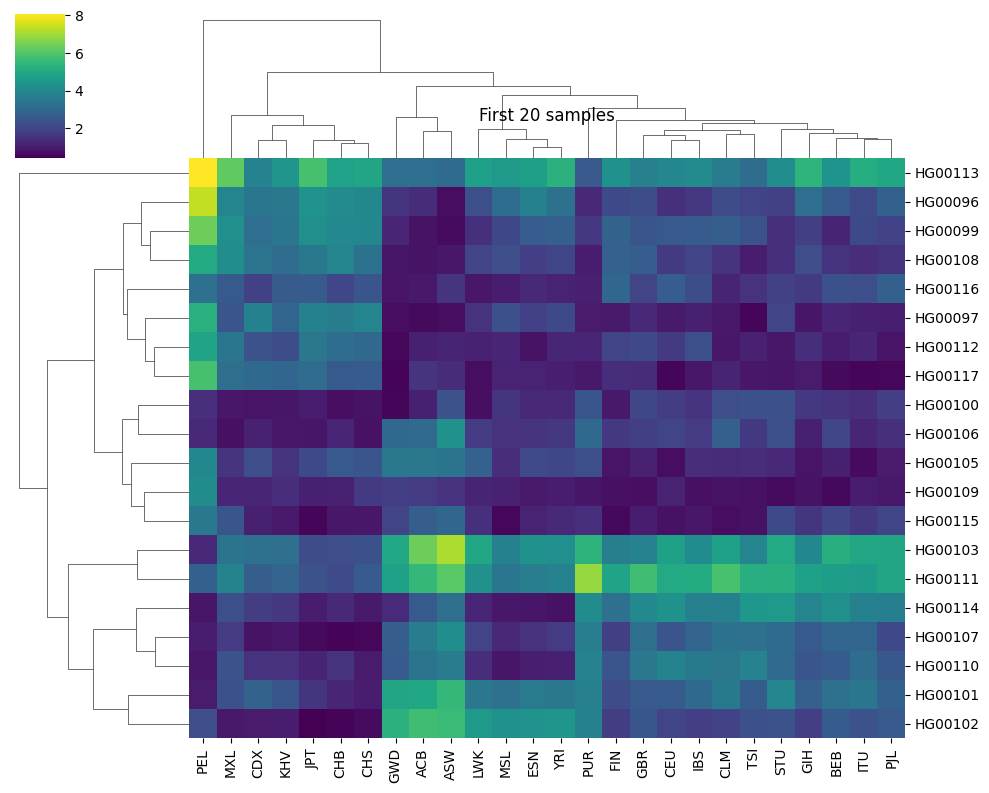

In [42]:
# 11. 带聚类的热图可视化
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage

# 取前面生成的距离矩阵
top20 = df.astype(float).iloc[:20]

# 行聚类
row_link = linkage(distance.pdist(top20.values), method='average')

plt.figure(figsize=(8, 8))
g = sns.clustermap(
    top20,
    cmap='viridis',
    linewidths=0,
    row_linkage=row_link,
    col_cluster=True,      # 种群方向也聚类
    xticklabels=True,
    yticklabels=True,
    figsize=(10, 8)
)
g.ax_heatmap.set_title("First 20 samples", y=1.05)
plt.show()